# Проектная работа: анализ данных пользователей сервиса GoFast

# Описание проекта

**Дано:** данные о некоторых пользователях из нескольких городов, а также об их поездках сервиса GoFast.   

Данные:

    Пользователи — users_go.csv
    Поездки — rides_go.csv
    Подписки — subscriptions_go.csv
    
Сервисом можно пользоваться:  

- без подписки

      абонентская плата отсутствует;
      стоимость одной минуты поездки — 8р;
      стоимость старта (начала поездки) — 50р

- с подпиской Ultra

      абонентская плата — 199 рублей в месяц;
      стоимость одной минуты поездки — 6 рублей;
      стоимость старта — бесплатно.    

---

**Цель исследования:** проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. 

**Гипотезы для проверки:**
- Тратят ли пользователи с подпиской больше времени на поездки?
- Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

**Ход исследования:**  

О данных мало что известно. Поэтому перед проверкой гипотез понадобится обзор данных.  
Нужно проверить данные на ошибки и оценить их влияние на исследование, проверить на начилие дубликатов или пропущенных значений.  
После визуализировать данные, пересобрать из них датафреймы, более удобные для проверки предоставленных гипотез.  
После чего уже проверить гипотезы.  

Таким образом, исследование пройдёт в три этапа:  

- Обзор данных
- Предобработка данных
- Проверка гипотез
     

In [1]:
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np

In [5]:
from math import factorial, sqrt

In [6]:
from scipy import stats as st

In [7]:
from scipy.stats import binom

In [8]:
from IPython.display import Image

### Шаг 1. Загрузка данных

#### Данные о пользователях


- user_id	уникальный идентификатор пользователя   
- name	имя пользователя  
- age	возраст  
- city	город  
- subscription_type	тип подписки (free, ultra)  

In [9]:
data_users = pd.read_csv('/datasets/users_go.csv')
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [10]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


#### Данные о поездках

- user_id	уникальный идентификатор пользователя
- distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date	дата совершения поездки

In [11]:
data_rides = pd.read_csv('/datasets/rides_go.csv')
data_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [12]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


#### Данные о подписках

- subscription_type	тип подписки
- minute_price	стоимость одной минуты поездки по данной подписке
- start_ride_price	стоимость начала поездки
- subscription_fee	стоимость ежемесячного платежа

In [13]:
data_sub = pd.read_csv('/datasets/subscriptions_go.csv')
data_sub

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [14]:
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


---

**Промежуточный вывод:**  

В таблице **users_go.csv** находится база данных пользователей по их id c данными о самих людях (имя, возраст, город, платят ли за подписку).    
В **rides_go.csv** данные о конкретных поездках, этих данных больше всего.  
В **subscriptions_go.csv** все характеристики двух возможных моделей подписки: платной и бесплатной.  

Предварительно можно утверждать, что, данных достаточно для проверки гипотез, но нужно проверить данные на наличие пропусков и дубликатов.

### Шаг 2. Предобработка данных

#### Столбец date и month в data_rides

In [15]:
# Привожу к datetime
data_rides['date'] = pd.to_datetime(
    data_rides['date'], format='%Y-%m-%d'
)

In [16]:
# Создаю новый столбец, содержащий номер месяца
data_rides['month'] = data_rides['date'].dt.month

In [17]:
data_rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [18]:
data_rides['date'].max()

Timestamp('2021-12-30 00:00:00')

В датасете data_rides приведены записи за 2021 год (кроме 31 декабря)

#### Работа с пропусками и дубликатами

**Проверю, есть ли пропуски данных в первых двух датафреймах (третий я уже видела целиком):**

In [19]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [20]:
data_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

**Пропусков нет, проверю на наличие дубликатов:** 
    
    в data_users дубликатами могут быть строки с одним user_id;
    в data_rides дубликатом будет полный дубликат строки.

In [21]:
data_users['user_id'].duplicated().sum()

31

In [22]:
data_users.duplicated().sum()

31

**Количество дубликатов в столбце user_id и полных дубликатов совпадает, просто уберу их**

In [23]:
data_users = data_users.drop_duplicates().reset_index()

In [24]:
data_users.duplicated().sum()

0

In [25]:
# в data_rides дубликатов нет
data_rides.duplicated().sum()

0

---

**Промежуточный вывод:**  

В ходе предобработки данных было определено, что в них нет пропусков;   
В одном из датафреймов был найден и удален 31 очевидный дубликат;  
Для неочевидных дубликатов ни в одной из таблиц подходящего места нет.  

Данные хорошего качества и подходят для проведения исследования.

### Шаг 3. Исследовательский анализ данных

#### Частота встречаемости городов

In [26]:
data_users['city'].value_counts(ascending=False)

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

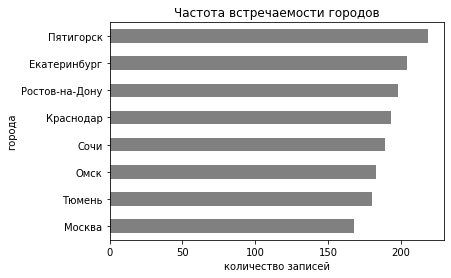

In [27]:
ax_city = data_users['city'].value_counts(ascending=True).plot(kind='barh', color='gray', title='Частота встречаемости городов');
ax_city.set_xlabel('количество записей');
ax_city.set_ylabel('города');

Больше всего пользователей самокатов проживает в Пятигорске, меньше всего в Москве;  
Всего городов в базе 8, пользователи довольно равномерно распределены по городам.

#### Соотношение пользователей с подпиской и без подписки

Всего есть два типа подписок: бесплатная и ультра

In [28]:
data_sub

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [29]:
data_users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

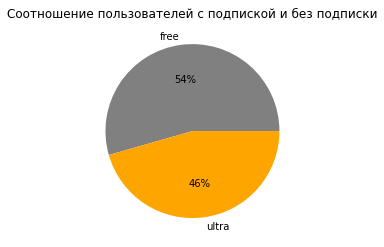

In [30]:
data_users['subscription_type'].value_counts().plot.pie(autopct='%1.0f%%', colors = ['grey', 'orange'], ylabel='',
                                                        title="Соотношение пользователей с подпиской и без подписки");

Пользователей без подписки незначительно 846 (54%), с подпиской ультра 719 (46%);  
Без подписки пользуется сервисом немного больше пользователей.

#### Возраст пользователей

In [31]:
data_users['age'].value_counts(ascending=False)

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

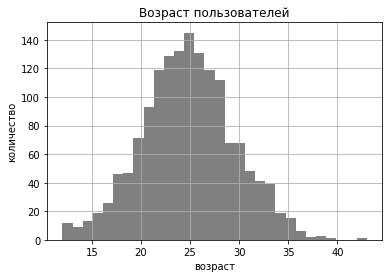

In [32]:
ax = data_users['age'].hist(bins=30, color = 'grey');
ax.set_xlabel('возраст');
ax.set_ylabel('количество');
ax.set_title('Возраст пользователей');

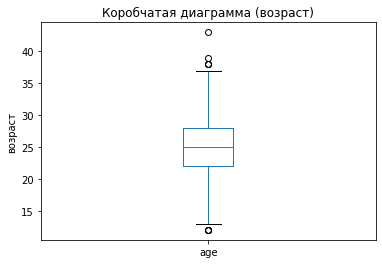

In [33]:
data_users['age'].plot(kind='box', title='Коробчатая диаграмма (возраст)',
                       ylabel = 'возраст');

In [34]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Большая часть пользователей - люди от 15 до 35 лет.

#### Расстояние, которое пользователь преодолел за одну поездку

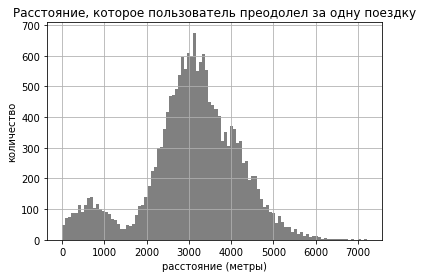

In [35]:
ax = data_rides['distance'].hist(bins=100, color='grey');
ax.set_xlabel('расстояние (метры)');
ax.set_ylabel('количество');
ax.set_title('Расстояние, которое пользователь преодолел за одну поездку');

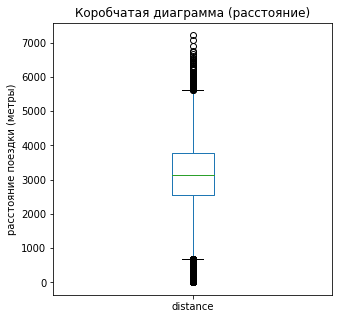

In [36]:
data_rides['distance'].plot(kind='box', figsize=(5, 5), title = 'Коробчатая диаграмма (расстояние)',
                            ylabel = 'расстояние поездки (метры)');

In [37]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

На графике расстояния видно два пика на ~500 метрах и на ~3000 метрах соответственно.  
Пик на 3000 метрах можно объяснить тем, что 3000 это достаточно большое расстояние, чтобы пользователь не хотел пройти его пешком и для него он скорее будет использовать самокат.  
Пик на 500 метрах значительно меньше и может быть связан и бытовыми задачами (например, перепарковать самокат у дома или совершить поездку от дома до стоянки и пересесть на метро).

#### Продолжительность поездок

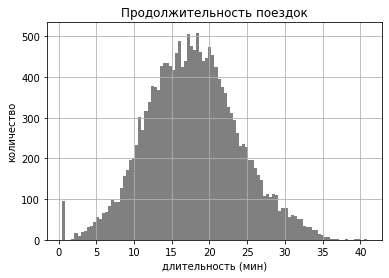

In [38]:
ax = data_rides['duration'].hist(bins=100, color='grey');
ax.set_xlabel('длительность (мин)');
ax.set_ylabel('количество');
ax.set_title('Продолжительность поездок');

In [39]:
data_rides.query('duration < 1'). shape[0]

95

In [40]:
data_rides.query('duration < 1')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


На графике можно увидеть пик значений около нуля. При ближайшем рассмотрении видно, что в данных есть 95 строк с длительностью поездки менее одной минуты, но расстоянием в тысячи метров. Вряд ли самокаты могут развивать такие скорости, скорее всего в данных ошибка.

In [41]:
data_rides.query('duration < 1')['duration'].unique()

array([0.5])

Так же вижу, что у всех этих аномальных значений время поездки 0.5 минут. Исключу эту аномалию из исследования.

In [42]:
data_rides = data_rides.query('duration > 1')
data_rides.shape[0]

17973

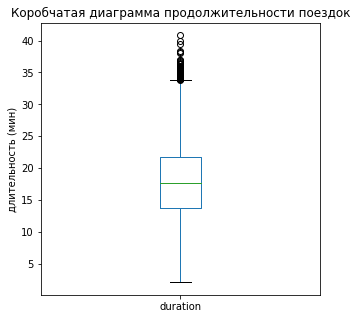

In [43]:
data_rides['duration'].plot(kind='box', figsize=(5, 5),
                            title = 'Коробчатая диаграмма продолжительности поездок',
                            ylabel = 'длительность (мин)');

In [44]:
data_rides['duration'].describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

Пользователи совершают поездки на самые разные расстояния за разное время;  
Бо́льшая часть поездок на расстояние от 2000м до 5000м и длиной от 10 до 20 минут.

### Шаг 4. Объединение данных

#### Объединяю данные о пользователях, поездках и подписках в один датафрейм. 

In [45]:
data_joined = data_rides.merge(data_users, on='user_id', how='left')
data_joined.head(10)

,user_id,distance,duration,date,month,index,name,age,city,subscription_type
0,1,4409.919140,25.599769,2021-01-01,1,0,Кира,22,Тюмень,ultra
1,1,2617.592153,15.816871,2021-01-18,1,0,Кира,22,Тюмень,ultra
2,1,754.159807,6.232113,2021-04-20,4,0,Кира,22,Тюмень,ultra
3,1,2694.783254,18.511000,2021-08-11,8,0,Кира,22,Тюмень,ultra
4,1,4028.687306,26.265803,2021-08-28,8,0,Кира,22,Тюмень,ultra
5,1,2770.890808,16.650138,2021-10-09,10,0,Кира,22,Тюмень,ultra
6,1,3039.020292,14.927879,2021-10-19,10,0,Кира,22,Тюмень,ultra
7,1,2842.118050,23.117468,2021-11-06,11,0,Кира,22,Тюмень,ultra
8,1,3412.690668,15.238072,2021-11-14,11,0,Кира,22,Тюмень,ultra
9,1,748.690645,15.041884,2021-11-22,11,0,Кира,22,Тюмень,ultra


In [46]:
data_joined_final = data_joined.merge(data_sub, on='subscription_type', how='left')
data_joined_final.head(10)

,user_id,distance,duration,date,month,index,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,0,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,0,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,0,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,0,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,0,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,0,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,0,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,0,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,0,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,0,Кира,22,Тюмень,ultra,6,0,199


In [47]:
data_rides.shape[0]

17973

In [48]:
data_joined_final.shape[0]

17973

#### Создам ещё два датафрейма из датафрейма выше: с подпиской и без

In [49]:
# C подпиской
data_ultra = data_joined_final.query('subscription_type == "ultra"')

In [50]:
# Без подсписки
data_free = data_joined_final.query('subscription_type == "free"')

#### Визуализирую информацию о расстоянии и времени поездок для пользователей обеих категорий

##### Расстояние

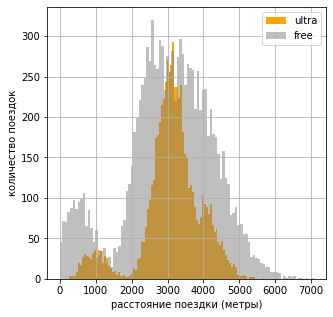

In [51]:
ax = data_ultra['distance'].hist(bins=100, color = 'orange', figsize=(5,5), legend = True);
data_free['distance'].hist(bins=100, color = 'grey', figsize=(5,5), ax=ax, alpha = 0.5, legend = True);

ax.set_ylabel('количество поездок');
ax.set_xlabel('расстояние поездки (метры)');
ax.legend(['ultra', 'free']);

##### Длительность

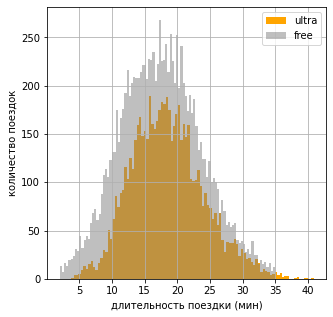

In [52]:
ax = data_ultra['duration'].hist(bins=100, color = 'orange', figsize=(5,5), legend = True);
data_free['duration'].hist(bins = 100, color = 'grey', figsize=(5,5), ax=ax, alpha=0.5, legend = True);

ax.set_ylabel('количество поездок');
ax.set_xlabel('длительность поездки (мин)');
ax.legend(['ultra', 'free']);

Коробчатые для ultra:

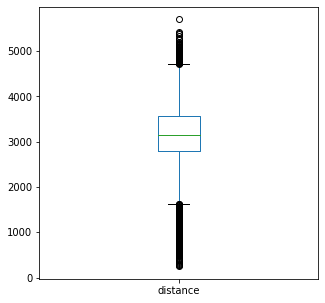

In [53]:
data_ultra['distance'].plot(kind='box', figsize=(5, 5));

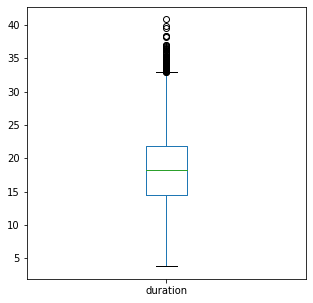

In [54]:
data_ultra['duration'].plot(kind='box', figsize=(5, 5));

Коробчатые для free:

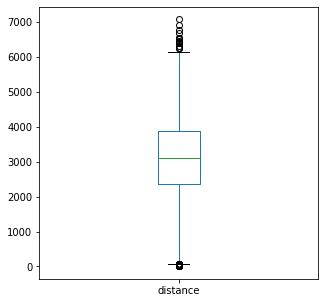

In [55]:
data_free['distance'].plot(kind='box', figsize=(5, 5));

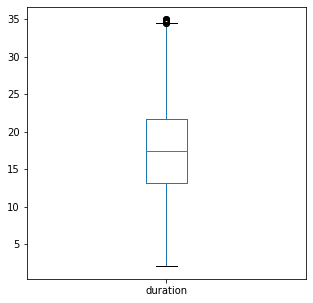

In [56]:
data_free['duration'].plot(kind='box', figsize=(5, 5));

---

---

**Помежуточный вывод:** 

По построенным гистограммам можно сказать:
- Поездки пользователей тарифа free явно объемнее и в расстоянии и в длительности;
- Если расстояния, на которые чаще ездят free и ultra пользователи, близки, то вот длительность free поездок явно выше ultra.

### Шаг 5. Подсчёт выручки

#### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [57]:
data_joined_final.head()

,user_id,distance,duration,date,month,index,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,0,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,0,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,0,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,0,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,0,Кира,22,Тюмень,ultra,6,0,199


In [58]:
# Округляю длительность каждой поездки в первой таблице
data_joined_final['duration'] = np.ceil(data_joined_final['duration']) 
data_joined_final.head()

,user_id,distance,duration,date,month,index,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26.0,2021-01-01,1,0,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16.0,2021-01-18,1,0,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,7.0,2021-04-20,4,0,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19.0,2021-08-11,8,0,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,27.0,2021-08-28,8,0,Кира,22,Тюмень,ultra,6,0,199


In [59]:
# Сводная таблица с суммарным расстоянием и длительностью поездок по месяцам
data_joined_pivot = pd.pivot_table(data_joined_final, 
                                   index=['user_id', 'month'],
                                   values=['duration', 
                                           'distance', 
                                           'subscription_type', 
                                           'minute_price',
                                           'start_ride_price', 
                                           'subscription_fee'],
                                   aggfunc={'user_id': 'count', 
                                            'duration' : 'sum', 
                                            'distance': 'sum', 
                                            'subscription_type': 'first',
                                            'minute_price' : 'first',
                                            'start_ride_price' : 'first',
                                            'subscription_fee' : 'first',
                                           }
                                  )
# Переименую столбец с подсчетом количества поездок
data_joined_pivot = data_joined_pivot.rename(
    columns={
        'user_id' : 'count'        
    }
)
data_joined_pivot.head(10)

distance  duration  minute_price  start_ride_price  \
user_id month                                                           
1       1       7027.511294      42.0             6                 0   
        4        754.159807       7.0             6                 0   
        8       6723.470560      46.0             6                 0   
        10      5809.911100      32.0             6                 0   
        11      7003.499363      56.0             6                 0   
        12      6751.629942      28.0             6                 0   
2       3      10187.723006      63.0             6                 0   
        4       6164.381824      40.0             6                 0   
        6       3255.338202      14.0             6                 0   
        7       6780.722964      48.0             6                 0   

               subscription_fee subscription_type  count  
user_id month                                             
1       1                   199             ultra      2  
        4                   199             ultra      1  
        8                   199             ultra      2  
        10                  199             ultra      2  
        11                  199             ultra      3  
        12                  199             ultra      2  
2       3                   199             ultra      3  
        4                   199             ultra      2  
        6                   199             ultra      1  
        7                   199             ultra      2

#### Добавьте столбец с помесячной выручкой, которую принёс каждый пользователь.

In [60]:
data_joined_pivot['monthly_payments'] = data_joined_pivot['start_ride_price']*data_joined_pivot['count'] + \
                                        data_joined_pivot['minute_price']*data_joined_pivot['duration'] + \
                                        data_joined_pivot['subscription_fee']
data_joined_pivot.head(5)

distance  duration  minute_price  start_ride_price  \
user_id month                                                          
1       1      7027.511294      42.0             6                 0   
        4       754.159807       7.0             6                 0   
        8      6723.470560      46.0             6                 0   
        10     5809.911100      32.0             6                 0   
        11     7003.499363      56.0             6                 0   

               subscription_fee subscription_type  count  monthly_payments  
user_id month                                                               
1       1                   199             ultra      2             451.0  
        4                   199             ultra      1             241.0  
        8                   199             ultra      2             475.0  
        10                  199             ultra      2             391.0  
        11                  199             ultra      3             535.0

### Шаг 6. Проверка гипотез

Уровень статистической значимости для всех гипотез - 5%, так как не указано иное.

#### Тратят ли пользователи с подпиской больше времени на поездки?

 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

Гипотезы:  
- Н0 : пользователи с подпиской тратят столько же времени на поездку, как и без
- Н1 : пользователи с подпиской тратят больше времени на поездку, чем без

In [61]:
alpha = 0.05

# выборки чуть разных размеров, equal_var=False
results = st.ttest_ind(
    data_ultra['duration'],
    data_free['duration'],
    equal_var=False,
    alternative='greater'
)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу, pvalue =', results.pvalue)
else:
    print('Не отвергаем нулевую гипотезу, pvalue =', results.pvalue)


Отвергаем нулевую гипотезу, pvalue = 1.6162210195311063e-29


In [62]:
data_ultra['duration'].mean()

18.54198516280583

In [63]:
data_free['duration'].mean()

17.530771268800226

Полученное pvalue не может превысить пороговые 5% - отвергаем гипотезу Н0 : "пользователи с подпиской тратят столько же времени на поездку, как и без", оставляем гипотезу Н1: "**пользователи с подпиской тратят больше времени на поездку, чем без**".

#### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Гипотезы:  
- Н0 : расстояние, которое проезжают пользователи с подпиской за одну поездку = 3130
- Н1 : расстояние, которое проезжают пользователи с подпиской за одну поездку > 3130

In [64]:
optimal_value = 3130

results = st.ttest_1samp(
    data_ultra['distance'],
    optimal_value,
    alternative='greater'
)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу, pvalue =', results.pvalue)
else:
    print('Не отвергаем нулевую гипотезу, pvalue =', results.pvalue)

Не отвергаем нулевую гипотезу, pvalue = 0.9195368847849785


Полученное pvalue превышает пороговые 5% - отвергнуть гипотезу Н0 : "**расстояние, которое проезжают пользователи с подпиской за одну поездку = 3130**" нельзя.

####  Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Гипотезы:  
- Н0 : выручка от пользователей с подпиской такая же, как и без
- Н1 : выручка от пользователей с подпиской больше, чем без

In [65]:
# выборки чуть разных размеров, equal_var=False
results = st.ttest_ind(
    data_joined_pivot.query('subscription_type == "ultra"')['monthly_payments'],
    data_joined_pivot.query('subscription_type == "free"')['monthly_payments'],
    equal_var=False,
    alternative='greater'
)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу, pvalue =', results.pvalue)
else:
    print('Не отвергаем нулевую гипотезу, pvalue =', results.pvalue)


Отвергаем нулевую гипотезу, pvalue = 2.4970242872858465e-38


In [66]:
data_joined_pivot.query('subscription_type == "ultra"')['monthly_payments'].mean()

362.7921906022502

In [67]:
data_joined_pivot.query('subscription_type == "free"')['monthly_payments'].mean()

329.3326437121324

Полученное pvalue не может превысить пороговые 5% - отвергаем гипотезу Н0 : "выручка от пользователей с подпиской такая же, как и без", оставляем гипотезу Н1: **"выручка от пользователей с подпиской больше, чем без"**.

#### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Выборки до обновления и после обновления - это зависимые выборки, т.к. переменная изменяется дважды для одних и тех же объектов. Пара изменений для каждого пользователя: до и после обновления.  
Чтобы проверить гипотезу о равенстве средних двух генеральных совокупностей для зависимых (парных) выборок применяется метод

`scipy.stats.ttest_rel()`
     
и передать ему выборки до и после     

#### 7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

|подписка|1|0|
|--|--|--|
|вероятность|0.1|0.9|

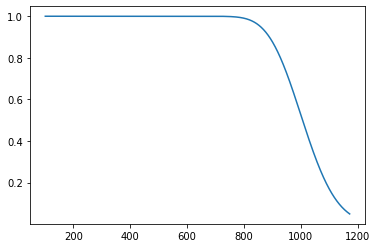

Нужно сделать 1172 рассылок


In [68]:
# binom.cdf(k,n,p)
# Надо успехов:
k=100
# Это мой x
n=100
# Вероятность успеха
p=0.1
# Наибольшая допустимая вероятность не получить меньше k
prob=0.05
# Надо подписок
k=100

x=[]
y=[]

while (binom.cdf(k,n,p) >= prob):
    n = n + 1
    x.append(n)
    y.append(binom.cdf(k,n,p))

# График     
plt.plot(x,y)
plt.show()

print('Нужно сделать', n, 'рассылок')

### 8 Вывод

**Цель исследования:** выполнить предобработку данных и изучить их, проверить некоторые данные гипотезы.  

**Входные данные:** данные о некоторых пользователях из нескольких городов, а также об их поездках сервиса GoFast. Датасеты следующие: данные о пользователях сервиса, данные о поездках, данные о подписках за 2021 г. 

---

Для более точного анализа была проведена работа по удалению пропусков, обработке аномальных значений и обработке дубликатов:

- Заменен формат даты на datetime в данных о поездках;
- Добавлен отдельный столбец month для дальнейшей работы;
- Удалены очевидные дубликаты в данных о пользователях;
- Удалены аномальные значеия в данных о поездках.

---

Некоторые параметры данных отражают следующие графики:

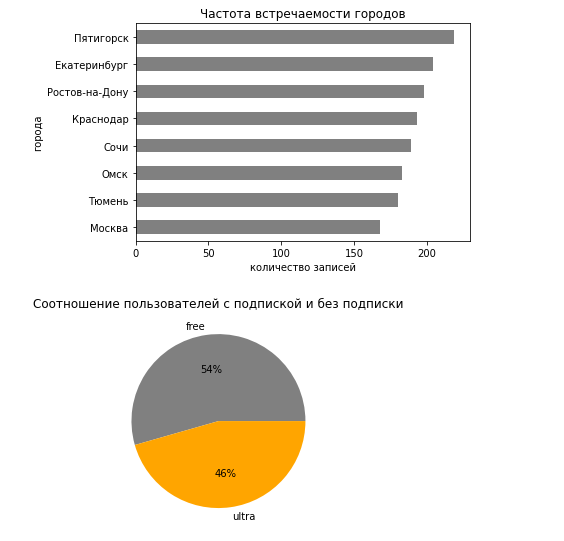
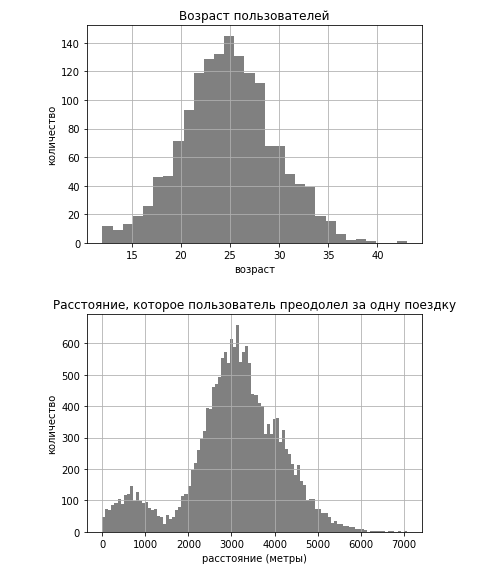
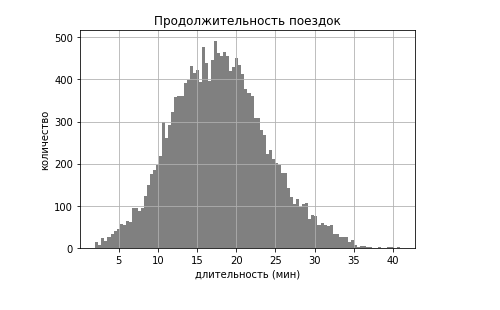


---

Так же в ходе исследования данные из трех датасетов были объединены в один общий + созданы два новых датасета отдельно для пользователей платной и бесплатной версии сервиса. Для сравнения расстояний и времени поездок бесплатных и платных пользователей привожу следующие графики: 

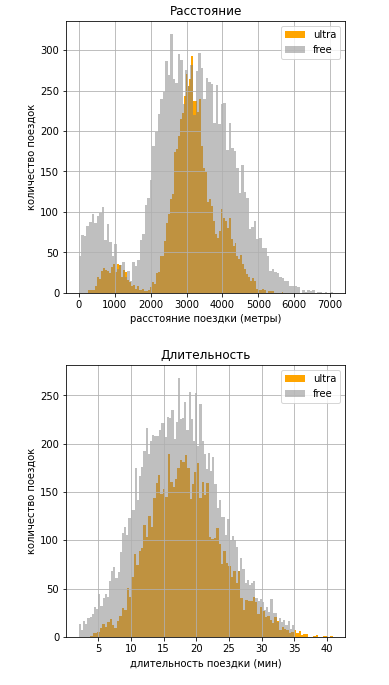

По графикам можно сделать промежуточный вывод, что пользователи free значительно чаще ездят по 10-25 минут, к тому же, поездки free на обоих графиках явно объемнее.

---

Так же, для удобства работы был создан агрегированный датафрейм, объединяющий в себе данные для каждого пользователя по месяцам, включая его тип подписки, общую длительность поездок, их расстояние.  

В этот датафрейм так же добавлен столбец с помесячной выручкой, которую приносил пользователь за 2021г.

--- 

Для анализа эффективности предстоящих акций, нужно блыо проверить три вещи:

- Тратят ли пользователи с подпиской больше времени на поездки?

      Не отвергнутая гипотеза: пользователи с подпиской тратят больше времени на поездку, чем без
      
- Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

      Не отвергнутая гипотеза: расстояние, которое проезжают пользователи с подпиской за одну поездку = 3130

- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

      Не отвергнутая гипотеза: выручка от пользователей с подпиской больше, чем без
      
---

**Итоговый вывод:** Подводя итог исследованию данных о пользователях, поездках и подписках сервиса GoFast можно сделать следующий вывод:  

Пользователи подписки free составляют незначительно большую часть всех пользователей сервиса; поездки ими совершаются более длительные и на большие расстояния, чем пользователями ultra.
Несмотря на это, анализ представленых гипотез показал, что выручка от пользователей с подпиской может быть больше, чем от пользователей без неё.

Исходя из этих выводов, можно дать рекомендацию продолжать проводить акции для привлечения пользователей подписки ultra, но так же расширить распространение free подписок.


      